# Домашняя работа

В этой работе вам предстоит с помощью encoder-decoder архитектуры, пробуя различные ее реализации, решить задачу машинного перевода.

#### Наша задача - сделать свой собственный переводчик!

Пока что только русско-английский:) Будем учиться на текстах описания отелей, так что при успешном выполнении этого задания у вас не возникнет проблем с выбором места для остановки в путешествии, так как все отзывы вам будут высококлассно переведены!

Что необходимо обсудить до начала работы?
 
*как токенезовать и закодировать текст?*

С токенезацией хорошо справится WordPunctTokenizer из библиотеки nltk, а вот с кодированием не все так просто, как может показаться... 

В наших текстах очень много редких и очень мало встречаемых слов (в каждом отеле есть своя фишка: какой-то предмет декорации или услуга, которая описывается своим словом, которое только там и встречается). Если мы будем кодировать все слова, то размер нашего словаря будет очень-очень большим.

Но на одном из семинаров мы кодировали побуквенно, кажется, что тут это может помочь! Да, действительно так, но придется очень очень долго обучать модель, а путешествовать и выбрать хороший отель уже хочется, поэтому мы придем к чему-то среднему между этими подходами -  [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) известный как __BPE__

Этот алгоритм стартует с посимвольного уровня и итеративно мерджит самые встречаемые пары. И так N итераций. На выходе мы получаем самые частые последовательности символов из которых формируются слова!

BPE - очень популярный и частоиспользуемый алгоритм в задачах NLP, поэтому есть много открытых реализаций этого алгоритма

Мы уверены, что вы научились гуглить и искать полезные материалы в интернете, когда делали домашнее задание по YOLO, поэтому в этот раз просто покажем один из способов, как это можно сделать и затем в своих проектах вы можете брать этот подход и, возможно, как-то улучшать его!

Тем кому очень интересно, как же все работает - заходите в файл vocab.py, очень советуем!

In [1]:
!pip install subword-nmt
!pip install evaluate
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 12.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=bc85991309e39755e82d0eb81fbe7f278eacddef88c8cd84bd9725b197dc0fbf
  Stored in directory: /root/.cache/pip/wheels/5b/e0/77/05245143a5b31f65af6a21f7afd3219e9fa4896f918af45677
Successfully built sacremoses


In [2]:
from IPython.display import clear_output
import IPython
from tqdm import tqdm
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
import numpy as np
from sklearn.model_selection import train_test_split
from vocab_utility import Vocab
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate.bleu_score import corpus_bleu
from torch.optim.lr_scheduler import StepLR, ExponentialLR, MultiStepLR
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
import datasets
from transformers import pipeline
from transformers import DataCollatorForSeq2Seq
import evaluate
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer

In [3]:
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# разбиваем и токенизируем тексты, записываем обработанные токены в файл
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('/kaggle/input/data-for-hw2/data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# строим и применяем bpe кодирование
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:12<00:00, 660.88it/s] 


### Построение словарей, разбиение данных

Сейчас, когда мы обучили BPE алгоритм на наших данных, построим словарь соответствия токена и его индекса, чтобы нам было затем удобно смотреть переводы и переводить новые предложения

Также сделаем разбиение на train/test

In [4]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [5]:
for i in range(3):
    print('inp:', dev_inp[i])
    print('out:', dev_out[i], end='\n\n')

inp: в распоряжении гостей общая кухня и общая гостиная .
out: a shared equipped kitchen and a common living room are provided to guests .

inp: на территории виллы sh@@ eng@@ si hu@@ a@@ jing находится сад и терраса .
out: at sh@@ eng@@ si hua@@ jing villa you will find a garden and a terrace .

inp: расстояние от отеля li@@ bu@@ š@@ e до ближайшей станции метро ko@@ by@@ lis@@ y ( линия с ), от которой можно добраться до центрального железнодорожного вокзала праги и центра города , составляет 500 метров .
out: the nearest metro station at ko@@ by@@ lis@@ y , on line c , is set 500 metres from hotel li@@ bu@@ š@@ e , and it offers connections towards prague main train station and the centre of the city .



In [6]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [7]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


## За вас сделали домашнюю работу? Нет, вам самое интересное!

Если вы пролистываете ноутбук и вам уже очень хочется начать писать самим - то мы вас понимаем, задание очень интересное и полезное! 
И спешим вас обрадовать, так как вы дождались и тут как раз можно проявить всю фантазию и мастерство написание нейронных сетей!


###  Задание 1 (1 балла)
В коде ниже мы представили шаблон простой encoder-decoder модели, без всяких наворотов с Attention или чем-нибудь еще. Вы можете редактировать его под себя: добавлять новые методы, новые переменные, писать на pytorch ligtning и другое.

Главное - сохраните идею шаблона и сделайте его очень удобным, так как с ним еще предстоит работать!

Заполните пропуски с `<YOUR CODE HERE>`

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
class BaseModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__() 

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
    def forward(self, inp, out):
        """ Сначала примените  encode а затем decode"""
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и 
        логиты для следующих токенов
        """
        prev_gru0_state = prev_state[0]
        out_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(out_emb, prev_gru0_state)
        output_logits = self.logits(new_dec_state)
        
        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # первый символ всегда BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        # в цикле делаем decode_step, получаем logits_sequence
        for i in range(out_tokens.shape[1] - 1):
            #print(i)
            state, output_logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(output_logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Генерим токены для перевода """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        """Функция для перевода"""
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [40]:
# debugging area
model = BaseModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [41]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
minimal@@ sar@@ latina loun@@ produces krak@@ aus@@ buenos hour ord depart@@ ten fer prince fur@@ mayo syl@@ 41 popular popular doors stand panoram@@ bæ@@ ent@@
minimal@@ sar@@ latina loun@@ produces stadt ak@@ for museums 33 . seattle war@@ museums castel ols plush gri@@ dong@@ sever@@ karl@@ monte o ento cos
minimal@@ sar@@ latina loun@@ produces krak@@ aus@@ buenos hour ord depart@@ ten fer prince fur@@ mayo syl@@ 41 popular popular doors stand panoram@@ bæ@@ ent@@


### Задание 2 (2 балла)

Тут нечего объяснять, нужно написать лосс, чтобы все училось:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

где $|D|$ это суммарная длина всех предложений включая все токены: BOS, EOS но не включая падинг 

In [42]:
def loss_function(model, inp, out, **flags):
    """
    Функция для подсчета лосса
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    Для того чтобы пройти тесты, ваша функция должна
    * учитывать в loss первый EOS, но НЕ учиттывать последующие
    * разделить loss на длину вхходящей последовательности (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)
    
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)
    # log-probabilities всех токеноы на всех шагах
    #logprobs_seq = torch.log(F.softmax(logits_seq, dim=-1)+F.softmax(logits_seq, dim=1).detach().min()*1e-1)# [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log(F.softmax(logits_seq, dim=-1)+1e-9)# [batch_size, out_len, num_tokens]

    # log-probabilities для верных ответов
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1) # [batch_size, out_len]
    # нужно обойтись только векторными операциями без for

    # cross-entropy по всем токенам где mask == True
    return -logp_out[mask].sum() / mask.sum() # тут должен получиться скаляр!

In [43]:
dummy_loss = loss_function(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1)

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.4327, device='cuda:0', grad_fn=<DivBackward0>)


### Метрика: BLEU

Для оценки машинного перевода обычно используется метрика [BLEU](https://en.wikipedia.org/wiki/BLEU). Она просто считает кол-во правильно предсказанных n-grams для n=1,2,3,4 и потом берет геометрическое среднее для полученных значений.

In [44]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    пример как считать метрику BLEU. Вы можете изменять вход и выход, 
    как вам удобно, главное оставьте логику ее подсчета!!!
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [45]:
compute_bleu(model, dev_inp, dev_out)

0.00398878460829792

### Training loop (1 балл)

Нужно просто написать цикл обучения и подсчитать метрики! И пройти assert по качеству

In [51]:
batch_size = 32
train_iterator = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(inp_voc.to_matrix(train_inp).to(device), out_voc.to_matrix(train_out).to(device)),
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BaseModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

num_iter = 20

In [ ]:
for epoch in tqdm(range(num_iter)):
    model.train()
    for data in train_iterator:
        inputs, targets = data
        opt.zero_grad()
        loss = loss_function(model, inputs, targets)
        loss.backward()
        opt.step()

    metrics['train_loss'].append(loss.item())
    
    model.eval()
    bleu = compute_bleu(model, dev_inp, dev_out)
    metrics['dev_bleu'].append(bleu)
    IPython.display.clear_output(wait=True)
    print('Loss after epoch '+str(epoch+1)+': '+str(metrics['train_loss'][-1]))
    print('Bleu after epoch '+str(epoch+1)+': '+str(metrics['dev_bleu'][-1]))
    #IPython.display.clear_output(wait=True)
    #print(f'\nLoss after epoch {epoch+1}: train_loss={metrics['train_loss'][-1]}, bleu={metrics['dev_bleu'][-1]}')
print('\nTraining process has finished.')

In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0) > 15, "Ты можешь больше! попробуй еще раз)"

In [ ]:
np.mean(metrics['dev_bleu'][-10:])

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
model = BaseModel(inp_voc, out_voc)
model.load_state_dict(torch.load('/kaggle/input/model-1-weights/model.pth'))
model.eval().to(device)

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

## Attention is all you need

### Задание 3

В этом разделе мы хотим, чтобы вы усовершенствовали базовую модель


Сначала напишем слой Attention, а потом внедрим его в уже существующий шаблон

### Attention layer (1 points)

На вход подается скрытые состояния encoder $h^e_0, h^e_1, h^e_2, ..., h^e_T$ и предыдущие состояние декодера $h^d$,

* Считаем логиты:
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получаем вероятности из логитов: 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвешиваем состояния энкодера с полученными вероятностями
$$ attn = \sum_t p_t \cdot h^e_t $$


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        super().__init__()
        self.name = name
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 
        
        # опишите все слои, которые нужны Attention
        self.linear_out = nn.Linear(hid_size, 1)
        self.linear_e = nn.Linear(enc_size, hid_size)
        self.linear_d = nn.Linear(dec_size, hid_size)

    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ and веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
        """
        
        c = self.linear_e(enc) + self.linear_d(dec).unsqueeze(1)
        a = self.linear_out(torch.tanh(c))#.squeeze(-1)
        a = torch.where(inp_mask.byte().unsqueeze(-1), a, -float('Inf'))
        probs = F.softmax(a, dim=1)
        attn = torch.sum(probs*enc, dim=1)
        
        return attn, probs

### Seq2seq model with attention (2 points)

Теперь вы можете использовать уровень внимания для построения сети. Самый простой способ реализовать внимание - использовать его на этапе декодирования:


На каждом шаге используйте предыдущее состояние декодера, и написанный слой Attention




In [79]:
class AttentiveModel(BaseModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """Переводчик с Attention"""
        nn.Module.__init__(self)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size)
        self.dropout = nn.Dropout(0.3)
        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size+hid_size, hid_size)
        self.logits = nn.Linear(emb_size+hid_size+hid_size, len(out_voc))
        self.attention = AttentionLayer(hid_size, hid_size, attn_size) 

    def encode(self, inp, **flags):
        """
        Считаем скрытые скрытые состояния, которые используем в decode
        :param inp: матрица входных токенов
        """
        #inp_emb = self.dropout(self.emb_inp(inp))
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)
        mask = inp_voc.compute_mask(inp)
        first_attn_state, first_attn_probas = self.attention(enc_seq, dec_start, mask)

        first_state = [dec_start, enc_seq, mask, first_attn_state, first_attn_probas]
        return first_state
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и логиты для следующих токенов
        :param prev_state: список тензоров предыдущих состояний декодера
        :param prev_tokens: предыдущие выходные токены [batch_size]
        :return: список тензоров состояния следующего декодера, тензор логитов [batch, n_tokens]
        """

        prev_gru0_state = prev_state[0]
        #out_emb = self.dropout(self.emb_out(prev_tokens))
        out_emb = self.emb_out(prev_tokens)
        attn = prev_state[3]

        out_emb = torch.cat((out_emb, attn), dim=-1)
        output_dec = self.dec0(out_emb, prev_gru0_state)
        output_logits = self.logits(torch.cat((out_emb, output_dec), dim=-1))
        attn, attn_prob = self.attention(prev_state[1], output_dec, prev_state[2])
        new_dec_state = [output_dec, prev_state[1], prev_state[2],  attn, attn_prob]

        return [new_dec_state, output_logits]


### Обучение модели (1 points)

Нужно обучить AttentiveModel и пройти assert по качеству

In [80]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(opt, gamma=0.9)
batch_size = 16
num_iter = 50

Loss after epoch 32: 1.3775675296783447
Bleu after epoch 32: 22.294980903875068


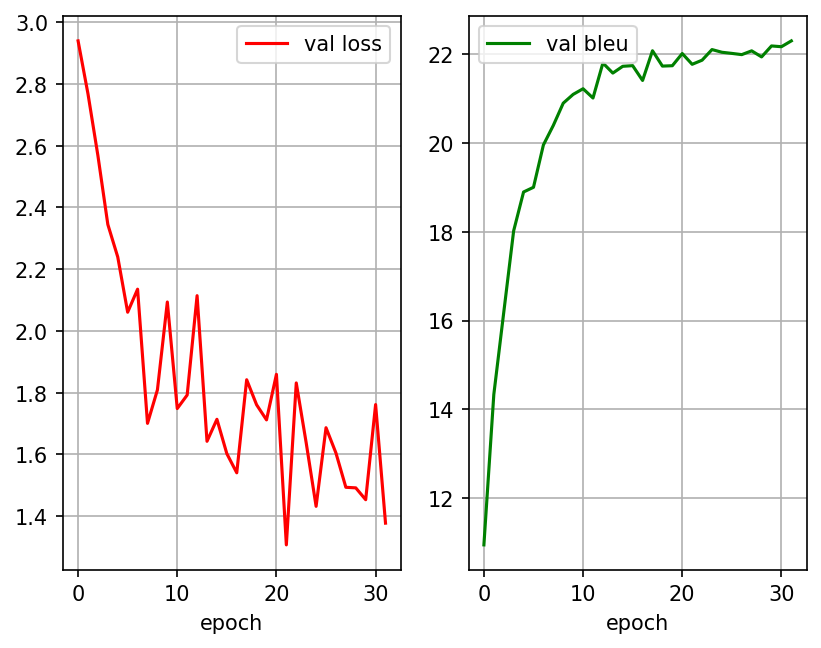

 64%|██████▍   | 32/50 [2:02:02<1:08:39, 228.84s/it]


KeyboardInterrupt: 

In [81]:
for epoch in tqdm(range(num_iter)):
    model.train()
    for data in train_iterator:
        inputs, targets = data
        opt.zero_grad()
        loss = loss_function(model, inputs, targets)
        loss.backward()
        opt.step()

    metrics['train_loss'].append(loss.item())
    scheduler.step()
    model.eval()
    bleu = compute_bleu(model, dev_inp, dev_out)
    metrics['dev_bleu'].append(bleu)
    IPython.display.clear_output(wait=True)
    print('Loss after epoch '+str(epoch+1)+': '+str(metrics['train_loss'][-1]))
    print('Bleu after epoch '+str(epoch+1)+': '+str(metrics['dev_bleu'][-1]))
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=150)
    ax1.grid()
    ax2.grid()
    ax1.plot(metrics['train_loss'], label='val loss', color='red')
    ax2.plot(metrics['dev_bleu'], label='val bleu', color='green')
    ax1.legend()
    ax2.legend()
    ax1.set_xlabel('epoch')
    ax2.set_xlabel('epoch')
    plt.show()

print('\nTraining process has finished.')

In [ ]:
print(f'Final bleu: {metrics["dev_bleu"][-1]}')
print(f'Max bleu: {max(metrics["dev_bleu"])}')
assert metrics["dev_bleu"][-1] > 23, "Ты можешь больше! попробуй еще раз)"

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

## Как решать NLP задачу? Дообучить модель из huggingface

Как мы видели на последнем семинаре в прошлом модуле можно получить отлично качество генерации текста, написав при этом не очень много строк кода, может быть попробовать тут также?)

Это отличная идея!

### Задание 4 (2 points)
 
Нужно взять модель из [huggingface](https://huggingface.co/models?pipeline_tag=translation&sort=downloads), дообучить на наших данных и посмотреть, какое качество

In [9]:
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")

model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en").to(device)

In [10]:
opt = torch.optim.Adam(model.parameters(), lr=1e-5)
metrics = {'train_loss': [], 'dev_bleu': [] }
batch_size = 32

In [11]:
translator = pipeline("translation", model=model, tokenizer=tokenizer)

In [12]:
train_translate = []
dev_translate = []
for i in range(train_inp.shape[0]):
    train_translate.append({'ru': train_inp[i], 'en': train_out[i]})

for i in range(dev_inp.shape[0]):
    dev_translate.append({'ru': dev_inp[i], 'en': dev_out[i]})

In [17]:
train_dataset = datasets.Dataset.from_dict({'translation': train_translate})
dev_dataset = datasets.Dataset.from_dict({'translation': dev_translate})

split_datasets = datasets.DatasetDict({"train":train_dataset, "dev":dev_dataset})

In [18]:
split_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 47001
    })
    dev: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
})

In [19]:
split_datasets["test"] = split_datasets.pop("dev")

In [20]:
split_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 47001
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
})

In [21]:
max_length = 128

def preprocess_function(examples):
    inputs = [ex["ru"] for ex in examples["translation"]]
    targets = [ex["en"] for ex in examples["translation"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    return model_inputs

In [22]:
tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names,
)

  0%|          | 0/48 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [23]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [24]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])

In [25]:
metric = evaluate.load("bleu")
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    #print(result)
    return {"bleu": result["bleu"]}

In [26]:
args = Seq2SeqTrainingArguments(
    '/kaggle/working/',
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
    report_to='none'
)

In [27]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [28]:
result_before_fine_tune = trainer.evaluate(max_length=max_length)

In [29]:
result_before_fine_tune

{'eval_loss': 3.799276113510132,
 'eval_bleu': 0.07419224390412171,
 'eval_runtime': 351.1208,
 'eval_samples_per_second': 8.544,
 'eval_steps_per_second': 0.134}

In [30]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss
500,1.835700
1000,1.385900
1500,1.269500
2000,1.166700
2500,1.118700
3000,1.093600
3500,1.054900
4000,1.039200


TrainOutput(global_step=4407, training_loss=1.2261667686550692, metrics={'train_runtime': 1195.3068, 'train_samples_per_second': 117.964, 'train_steps_per_second': 3.687, 'total_flos': 3757645934493696.0, 'train_loss': 1.2261667686550692, 'epoch': 3.0})

In [31]:
result_after_fine_tune = trainer.evaluate(max_length=max_length)

In [34]:
bleu = result_after_fine_tune['eval_bleu']*100

assert bleu > 27, "Ты можешь больше! попробуй еще раз)"

In [36]:
result_after_fine_tune['eval_bleu']*100

38.11600627217692